# IMPORTING LIBRARIES

In [1]:
import spacy

# Load a pre-trained NER model
nlp = spacy.load("en_core_web_sm")

# Process a text
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")

# Print recognized entities
for ent in doc.ents:
    print(ent.text, ent.label_)

2024-07-31 22:40:34.184396: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-31 22:40:34.239785: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-31 22:40:34.255984: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-31 22:40:34.297848: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-31 22:40:35.987571: W tensorflow/compiler/tf2

Apple ORG
U.K. GPE
$1 billion MONEY


In [10]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split
import ast
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense,Input,Bidirectional,LSTM,Embedding, Masking, SimpleRNN
from keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
sns.set(style="whitegrid")
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import os

# READING THE FILE PATH

In [13]:
def loading_data(data_path):
    
    data = pd.read_csv(data_path)
    
    data.dropna(inplace=True)
    print("Number of rows : ",data.shape[0]," and the number of columns : ",data.shape[1])
    
    return data

#  SAMPLE OF NER DATA

In [17]:
data = loading_data(r"/home/pranav/Spacy_nlp/ner_csv/ner.csv")

Number of rows :  47959  and the number of columns :  4


In [18]:
data.sample(5).sample(5).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

,Sentence #,Sentence,POS,Tag
4176,Sentence: 4177,"Pakistan has successfully tested a surface-to-surface missile with a range of 2,500 kilometers .","['NNP', 'VBZ', 'RB', 'VBN', 'DT', 'JJ', 'NN', 'IN', 'DT', 'NN', 'IN', 'CD', 'NNS', '.']","['B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
16306,Sentence: 16307,Agricultural production is limited - only 2 % of the land is arable - and most food has to be imported .,"['JJ', 'NN', 'VBZ', 'VBN', 'IN', 'RB', 'CD', 'NN', 'IN', 'DT', 'NN', 'VBZ', 'JJ', ':', 'CC', 'RBS', 'NN', 'VBZ', 'TO', 'VB', 'VBN', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
1940,Sentence: 1941,Rogers also says the actions documented in his book provide ample grounds for Than Shwe to be brought to trial for war crimes and crimes against humanity .,"['NNP', 'RB', 'VBZ', 'DT', 'NNS', 'VBN', 'IN', 'PRP$', 'NN', 'VB', 'JJ', 'NNS', 'IN', 'NNP', 'NNP', 'TO', 'VB', 'VBN', 'TO', 'NN', 'IN', 'NN', 'NNS', 'CC', 'NNS', 'IN', 'NN', '.']","['B-per', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
12145,Sentence: 12146,"In return , India is to separate its civilian and military nuclear programs and allow international inspection of its civilian facilities .","['IN', 'NN', ',', 'NNP', 'VBZ', 'TO', 'VB', 'PRP$', 'JJ', 'CC', 'JJ', 'JJ', 'NNS', 'CC', 'VB', 'JJ', 'NN', 'IN', 'PRP$', 'JJ', 'NNS', '.']","['O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
22455,Sentence: 22456,"Macau 's economy slowed dramatically in 2009 as a result of the global economic slowdown , but strong growth resumed in 2010 , largely on the back of strong tourism and gaming sectors .","['NNP', 'POS', 'NN', 'VBD', 'RB', 'IN', 'CD', 'IN', 'DT', 'NN', 'IN', 'DT', 'JJ', 'JJ', 'NN', ',', 'CC', 'JJ', 'NN', 'VBD', 'IN', 'CD', ',', 'RB', 'IN', 'DT', 'NN', 'IN', 'JJ', 'NN', 'CC', 'NN', 'NNS', '.']","['B-geo', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"


#  DATA PREPROCESSING

In [19]:
def preprocess_data(data):
    for i in range(len(data)):
        pos = ast.literal_eval(data.loc[i, 'POS'])
        tags = ast.literal_eval(data.loc[i, 'Tag'])
        data.loc[i, 'POS'] = [str(word) for word in pos]
        data.loc[i, 'Tag'] = [str(word.upper()) for word in tags]
    return data

In [20]:
data = preprocess_data(data)

In [21]:
data.sample(5).style.set_properties(**{'background-color': '#f9f9f9', 'color': '#4CAF50', 'font-weight': 'bold'})

,Sentence #,Sentence,POS,Tag
37832,Sentence: 37833,The match ended in a 01-Jan draw .,"['DT', 'NN', 'VBD', 'IN', 'DT', 'JJ', 'NN', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
26594,Sentence: 26595,Security for the election remains a concern .,"['NN', 'IN', 'DT', 'NN', 'VBZ', 'DT', 'NN', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"
19638,Sentence: 19639,The officials say the decision resolves an impasse among summit delegates in Khartoum over host-country Sudan 's bid for the chairmanship .,"['DT', 'NNS', 'VBP', 'DT', 'NN', 'VBZ', 'DT', 'NN', 'IN', 'NN', 'NNS', 'IN', 'NNP', 'IN', 'JJ', 'NNP', 'POS', 'NN', 'IN', 'DT', 'NN', '.']","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GEO', 'O', 'O', 'B-GPE', 'O', 'O', 'O', 'O', 'O', 'O']"
32032,Sentence: 32033,West Virginia is the state where 12 miners died after an explosion in the Sago coal mine in January 2006 .,"['NNP', 'NNP', 'VBZ', 'DT', 'NN', 'WRB', 'CD', 'NNS', 'VBD', 'IN', 'DT', 'NN', 'IN', 'DT', 'NNP', 'NN', 'NN', 'IN', 'NNP', 'CD', '.']","['B-GEO', 'I-GEO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-GEO', 'O', 'O', 'O', 'B-TIM', 'I-TIM', 'O']"
1583,Sentence: 1584,The United States had offered a $ 5 million reward for information leading to the arrest and conviction of each of the brothers .,"['DT', 'NNP', 'NNPS', 'VBD', 'VBN', 'DT', '$', 'CD', 'CD', 'NN', 'IN', 'NN', 'VBG', 'TO', 'DT', 'NN', 'CC', 'NN', 'IN', 'DT', 'IN', 'DT', 'NNS', '.']","['O', 'B-GEO', 'I-GEO', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']"


#  TRAIN-TEST-SPLIT

In [22]:
df_final = data[['Sentence','Tag']]

In [23]:
df_train,df_test = train_test_split(df_final,test_size=0.2,random_state=42)
len(df_train),len(df_test)

(38367, 9592)

#  TOKENIZATION

In [24]:
train_targets = list(df_train.Tag.values)
test_targets = list(df_test.Tag.values)

tokenizer = Tokenizer(lower=False,oov_token="UNK")
tokenizer.fit_on_texts(df_train['Sentence'])

train_inputs = tokenizer.texts_to_sequences(df_train['Sentence'])
test_inputs = tokenizer.texts_to_sequences(df_test['Sentence'])

In [25]:
word2idx = tokenizer.word_index
V = len(word2idx) # Vocab size
print("Found %s unique tokens "%V)

Found 28761 unique tokens 


In [26]:
train_tags = set([val for sublist in train_targets for val in sublist])
test_tags = set([val for sublist in test_targets for val in sublist])

print("Unique NER tags in train set: ",train_tags)
print("Unique NER tags in test set: ",test_tags)

Unique NER tags in train set:  {'B-PER', 'I-ORG', 'I-PER', 'B-GPE', 'I-EVE', 'I-GEO', 'I-TIM', 'I-GPE', 'B-ART', 'B-ORG', 'B-EVE', 'B-GEO', 'O', 'B-TIM', 'B-NAT', 'I-NAT', 'I-ART'}
Unique NER tags in test set:  {'B-PER', 'I-ORG', 'I-PER', 'B-GPE', 'I-EVE', 'I-GEO', 'I-TIM', 'I-GPE', 'B-ART', 'B-ORG', 'B-EVE', 'B-GEO', 'O', 'B-TIM', 'B-NAT', 'I-NAT', 'I-ART'}


In [27]:
tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(train_targets)
train_tgt_int = tag_tokenizer.texts_to_sequences(train_targets)
test_tgt_int = tag_tokenizer.texts_to_sequences(test_targets)

#  PADDING-SEQUENCE

In [28]:
# Max length
max_length_train = max(len(sent) for sent in train_inputs)
max_length_test = max(len(sent) for sent in test_inputs)
max_length = max(max_length_train,max_length_test)

# Pad input sequences
train_inputs_final = pad_sequences(train_inputs,maxlen=max_length,padding="post")
print("Shape of train inputs: ",train_inputs_final.shape)

test_inputs_final = pad_sequences(test_inputs,maxlen=max_length,padding="post")
print("Shape of test inputs: ",test_inputs_final.shape)

train_targets_final = pad_sequences(train_tgt_int,maxlen=max_length,padding="post")
print("Shape of train targets: ",train_targets_final.shape)

test_targets_final = pad_sequences(test_tgt_int,maxlen=max_length,padding="post")
print("Shape of test targets: ",test_targets_final.shape)

Shape of train inputs:  (38367, 89)
Shape of test inputs:  (9592, 89)
Shape of train targets:  (38367, 89)
Shape of test targets:  (9592, 89)


In [70]:
# Number of classes

K = len(tag_tokenizer.word_index)  +1
K

18

In [48]:
max_length = 89

#  MODEL-1 (LSTM)

In [44]:
from keras.layers import SimpleRNN

In [52]:
# A simpleRNN without any pretrained embeddings and one dense layer
#model = Sequential()
#model.add(Embedding(K ,300,input_length=max_length))
#model.add(SimpleRNN(100))
#model.add(Dense(1, activation='sigmoid'))
#model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
#model.summary()

In [71]:

#V = 10000
V = len(word2idx)
K = 18 

In [72]:
vector_size = 16
i = Input(shape=(max_length,))
x = Embedding(input_dim=V+1, output_dim=vector_size, mask_zero=True)(i)
x = Masking()(x)  # Masking layer to handle variable length sequences
x = Bidirectional(LSTM(32, return_sequences=True))(x)
x = Dense(K)(x)

model = Model(i, x)

In [73]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 89)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 89, 16)    │    460,192 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, 89, 16)    │          0 │ embedding_7[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking_3 (Masking) │ (None, 89, 16)    │          0 │ embedding_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any_3 (Any)         │ (None, 89)        │          0 │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 89, 64)    │     12,544 │ masking_3[0][0],  │
│ (Bidirectional)     │                   │            │ any_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 89, 18)    │      1,170 │ bidirectional_3[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 473,906 (1.81 MB)

 Trainable params: 473,906 (1.81 MB)

 Non-trainable params: 0 (0.00 B)

In [75]:
# Compile the model with the custom F1Score metric
model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

#  MODEL TRAINING

In [76]:
print(f"train_inputs_final shape: {train_inputs_final.shape}")
print(f"train_targets_final shape: {train_targets_final.shape}")
print(f"test_inputs_final shape: {test_inputs_final.shape}")
print(f"test_targets_final shape: {test_targets_final.shape}")

train_inputs_final shape: (38367, 89)
train_targets_final shape: (38367, 89)
test_inputs_final shape: (9592, 89)
test_targets_final shape: (9592, 89)


In [64]:
train_inputs_final

array([[   8, 3788,   47, ...,    0,    0,    0],
       [ 145,   38,   18, ...,    0,    0,    0],
       [   8, 2819, 2349, ...,    0,    0,    0],
       ...,
       [  57,    6,  464, ...,    0,    0,    0],
       [2046,  234,   29, ...,    0,    0,    0],
       [  46,  160,   12, ...,    0,    0,    0]], dtype=int32)

In [77]:
checkpoint = ModelCheckpoint(r"/home/pranav/Spacy_nlp/model_checkpoint.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)

# Train the model with callbacks
history = model.fit(
    train_inputs_final,
    train_targets_final,
    epochs=1,
    validation_data=(test_inputs_final, test_targets_final),
    callbacks=[checkpoint, early_stopping]
)

1198/1199 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9179 - loss: 0.3930
Epoch 1: val_loss improved from inf to 0.14566, saving model to /home/pranav/Spacy_nlp/model_checkpoint.keras
1199/1199 ━━━━━━━━━━━━━━━━━━━━ 62s 49ms/step - accuracy: 0.9179 - loss: 0.3927 - val_accuracy: 0.9574 - val_loss: 0.1457
Restoring model weights from the end of the best epoch: 1.


In [78]:
# Save the model to a file using tf.keras.models.save_model()
tf.keras.models.save_model(model, "ner_model.h5")

#  MODEL TRAINING GRAPH

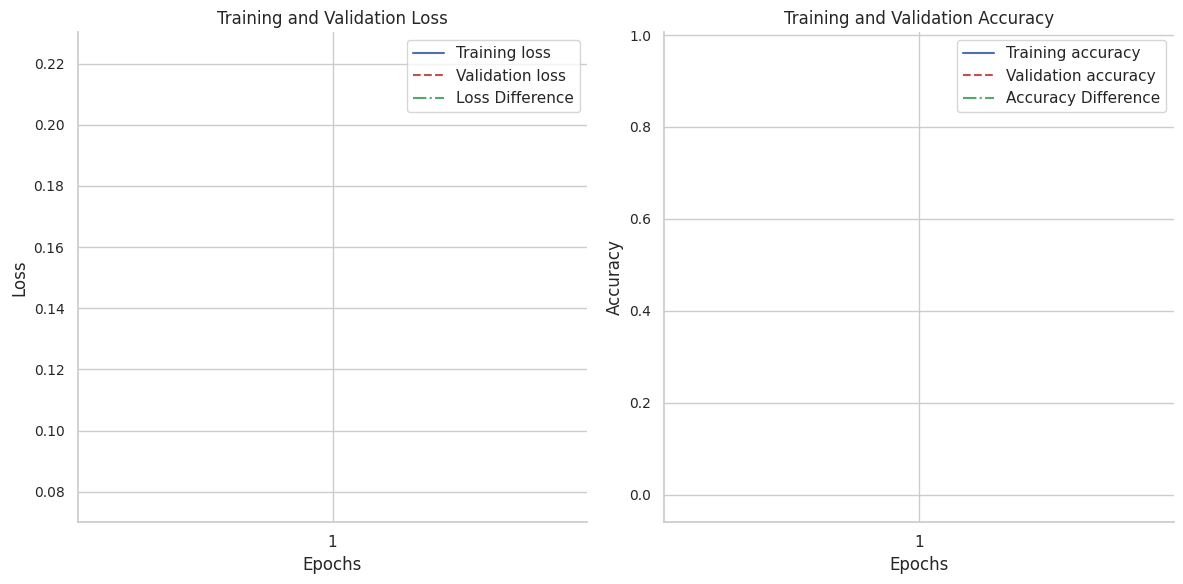

In [79]:
sns.set(style="whitegrid")

# Get training history
train_loss = history.history['loss']
train_acc = history.history['accuracy']
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

# Calculate differences
loss_diff = [train_loss[i] - val_loss[i] for i in range(len(train_loss))]
acc_diff = [train_acc[i] - val_acc[i] for i in range(len(train_acc))]

# Plot training and validation loss in subplots
plt.figure(figsize=(12, 6))

# Subplot 1: Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b-', label='Training loss')
plt.plot(epochs, val_loss, 'r--', label='Validation loss')
plt.plot(epochs, loss_diff, 'g-.', label='Loss Difference')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(epochs)
plt.yticks(fontsize=10)

# Subplot 2: Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'b-', label='Training accuracy')
plt.plot(epochs, val_acc, 'r--', label='Validation accuracy')
plt.plot(epochs, acc_diff, 'g-.', label='Accuracy Difference')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xticks(epochs)
plt.yticks(fontsize=10)

plt.tight_layout()

# Show plot
plt.show()

#  MODEL PREDICTION

In [80]:
unique_tags = ['O', 'B-GEO', 'B-GPE', 'B-ORG', 'B-PER', 'B-ART', 'B-EVE', 'B-NAT', 'B-TIM', 
               'I-GEO', 'I-GPE', 'I-ORG', 'I-PER', 'I-ART', 'I-EVE', 'I-NAT', 'I-TIM', 'PAD']  # Added 'PAD' tag

In [81]:
# Define your sample sentence
sentence = "Polish Prime Minister Jaroslaw Kaczynski has voiced support for the deployment of 10 U.S. missile interceptors in Poland and guidance technology in the Czech Republic."

# Preprocess the sentence
tokenized_sentence = tokenizer.texts_to_sequences([sentence])
padded_sentence = pad_sequences(tokenized_sentence, maxlen=max_length, padding="post")

# Make predictions
predictions = model.predict(padded_sentence)
prediction_ner = np.argmax(predictions, axis=-1)

# Check the shapes and classes
print(f"Shape of predictions array: {predictions.shape}")
print(f"Number of unique tags: {len(unique_tags)}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
Shape of predictions array: (1, 89, 18)
Number of unique tags: 18


In [84]:
# Ensuring the number of classes matches the length of unique_tags
assert len(unique_tags) == predictions.shape[-1], "Number of classes does not match the length of unique tags"

# Get the predicted tags
predicted_tags = [[unique_tags[idx] for idx in sentence] for sentence in prediction_ner]

# Example sentence and its predictions
example_sentence = sentence.split()  # Use sentence tokens instead of dummy 'tokens'
example_predictions = predicted_tags[0]

# Displaying the tokens with their predicted tags
from tabulate import tabulate
table = [[token, tag] for token, tag in zip(example_sentence, example_predictions)]
print(tabulate(table, headers=["Token", "Predicted NER Tag"], tablefmt="grid"))

+--------------+---------------------+
| Token        | Predicted NER Tag   |
+==============+=====================+
| Polish       | B-EVE               |
+--------------+---------------------+
| Prime        | B-EVE               |
+--------------+---------------------+
| Minister     | B-ART               |
+--------------+---------------------+
| Jaroslaw     | B-ART               |
+--------------+---------------------+
| Kaczynski    | B-ART               |
+--------------+---------------------+
| has          | B-GEO               |
+--------------+---------------------+
| voiced       | B-GEO               |
+--------------+---------------------+
| support      | B-GEO               |
+--------------+---------------------+
| for          | B-GEO               |
+--------------+---------------------+
| the          | B-GEO               |
+--------------+---------------------+
| deployment   | B-GEO               |
+--------------+---------------------+
| of           | B-GEO   

In [85]:
import warnings

# Suppress specific seaborn warning
warnings.filterwarnings("ignore", message=".*The `size` parameter has been renamed to `height`.*")
warnings.filterwarnings("ignore", message=".*The `xticks` positional argument has been renamed to `x`.*")

#  MODEL PREDICTION GRAPH

/tmp/ipykernel_43797/51658210.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique_tags, y=predictions[0][0], palette='coolwarm', edgecolor='black')


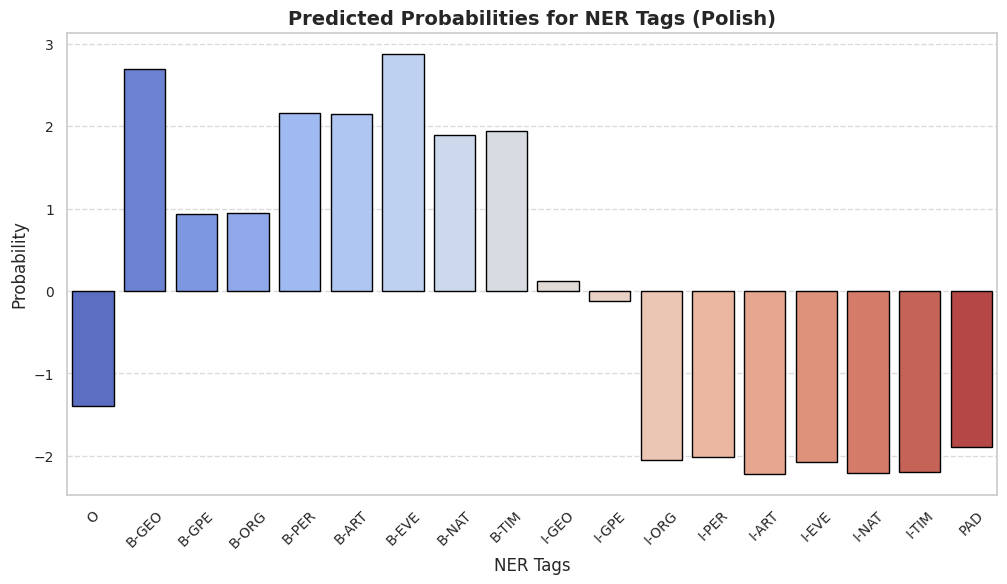

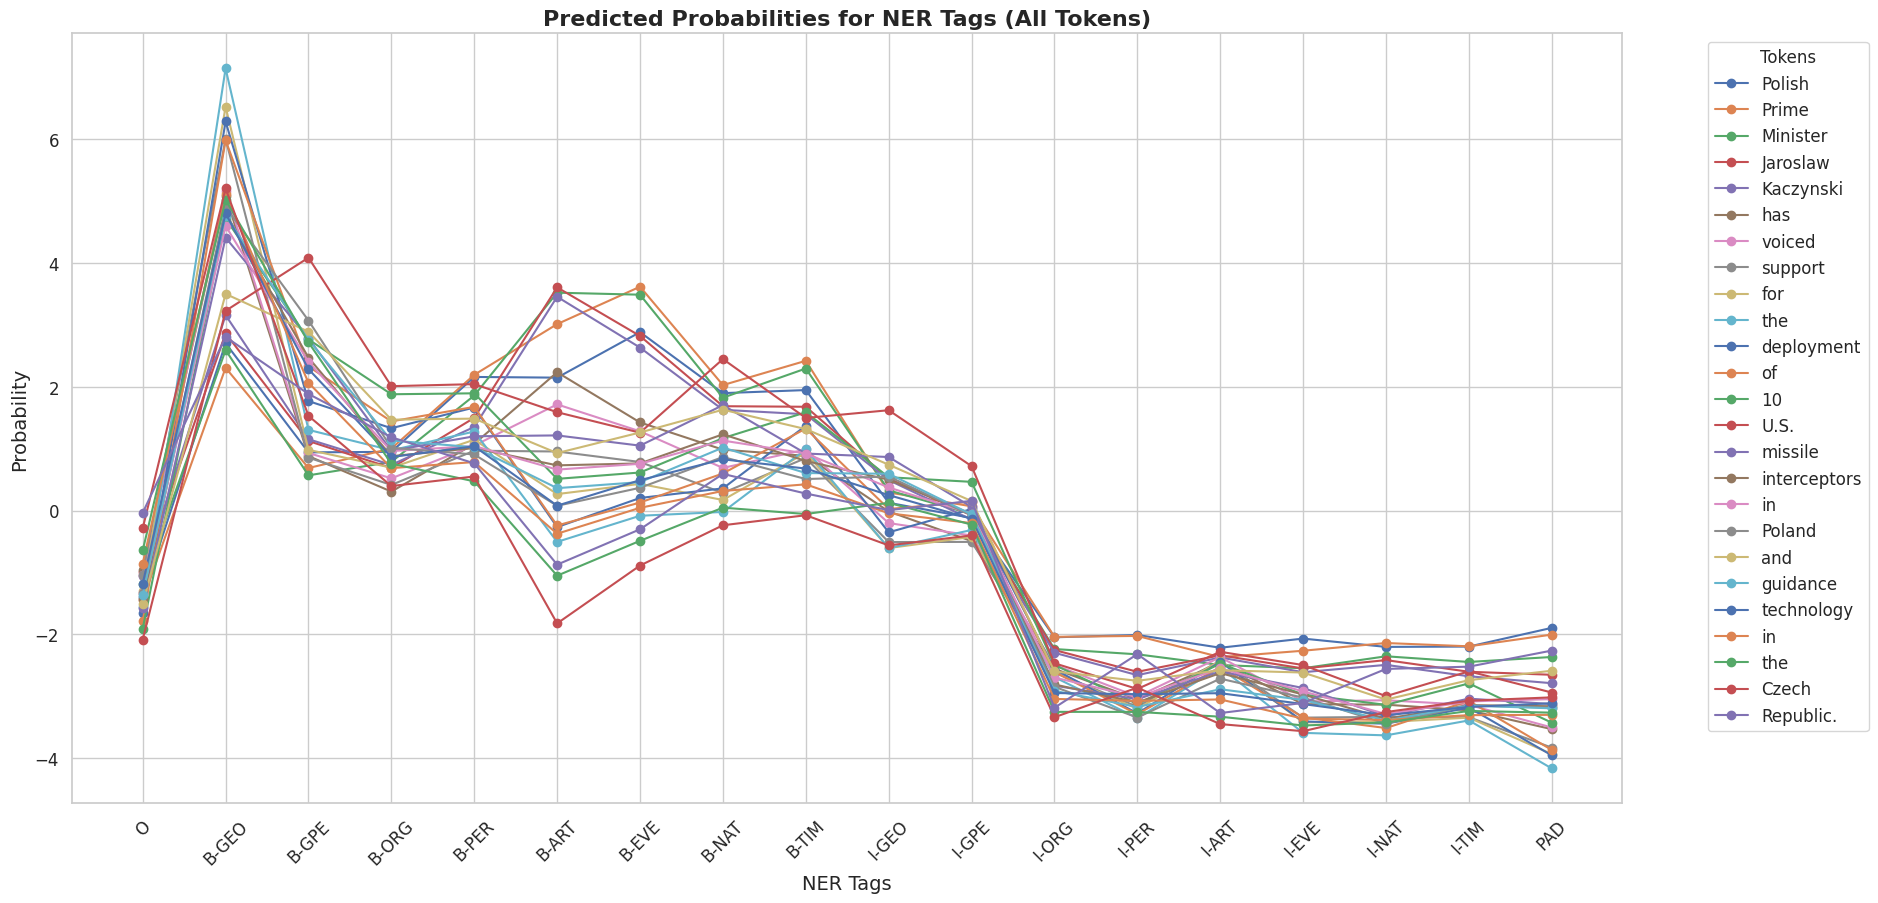

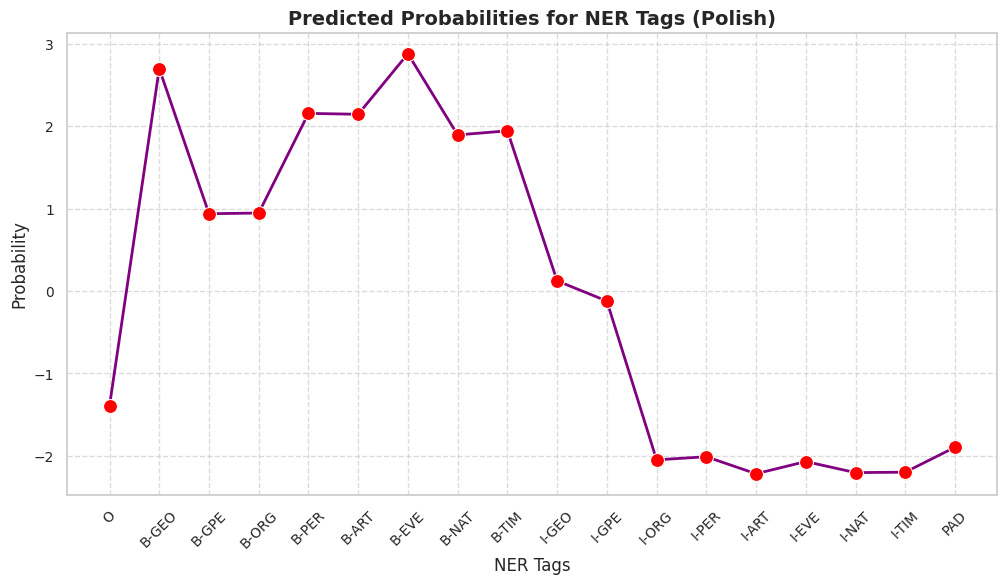

In [86]:
# Bar Plot for the first token
plt.figure(figsize=(12, 6))
sns.barplot(x=unique_tags, y=predictions[0][0], palette='coolwarm', edgecolor='black')
plt.title(f'Predicted Probabilities for NER Tags ({example_sentence[0]})', fontsize=14, weight='bold')
plt.xlabel('NER Tags', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(20, 10))
# Plotting line plots for each token
for i, token in enumerate(example_sentence):
    plt.plot(unique_tags, predictions[0][i], label=token, marker='o')

plt.title('Predicted Probabilities for NER Tags (All Tokens)', fontsize=16, weight='bold')
plt.xlabel('NER Tags', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title='Tokens', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.grid(True)
plt.show()
# Line Plot for the first token
plt.figure(figsize=(12, 6))
sns.lineplot(x=unique_tags, y=predictions[0][0], marker='o', linestyle='-', color='purple', markerfacecolor='red', markersize=10, lw=2)
plt.title(f'Predicted Probabilities for NER Tags ({example_sentence[0]})', fontsize=14, weight='bold')
plt.xlabel('NER Tags', fontsize=12)
plt.ylabel('Probability', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

# MODEL PREDICTION GRAPH

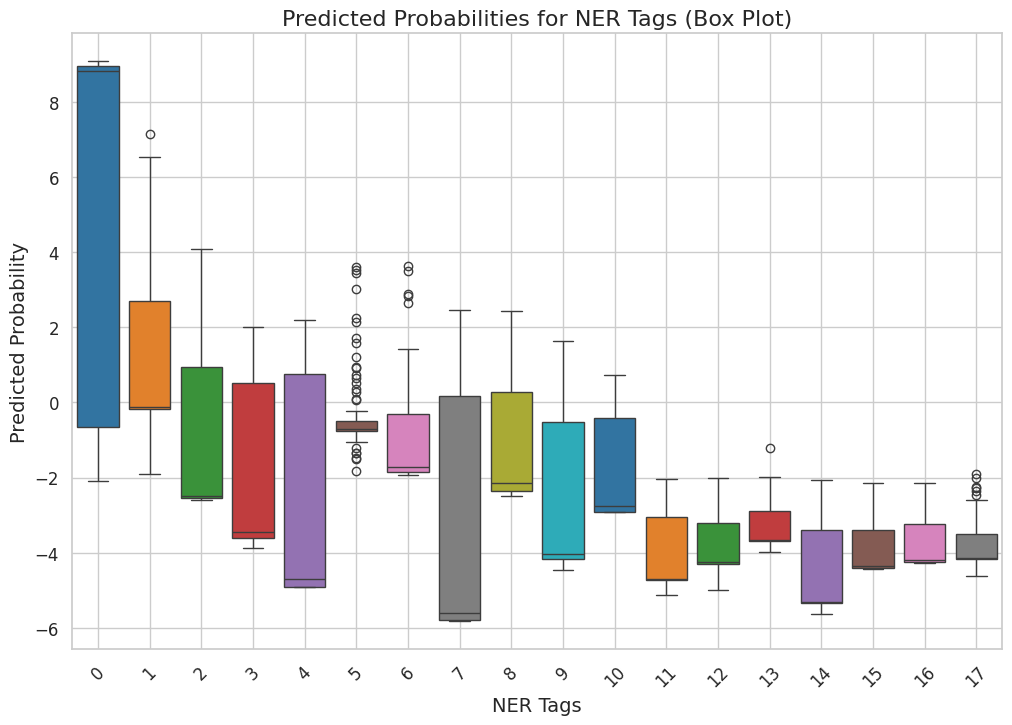

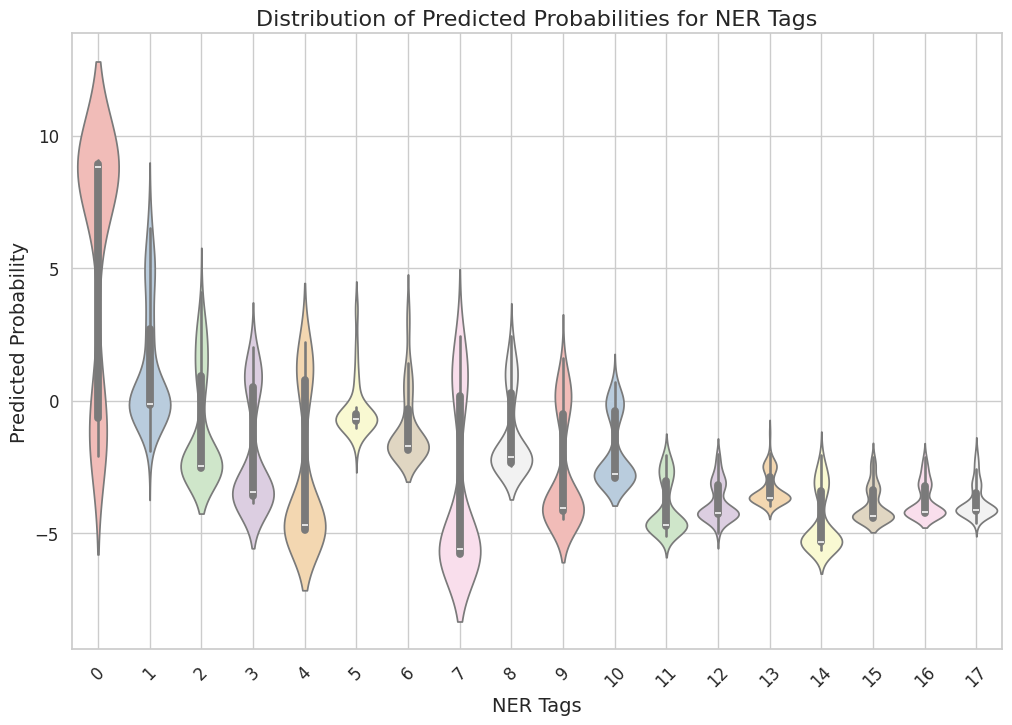

/tmp/ipykernel_43797/550006124.py:25: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(data=predictions[0], markers='o', join=False, ci='sd')
/tmp/ipykernel_43797/550006124.py:25: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(data=predictions[0], markers='o', join=False, ci='sd')


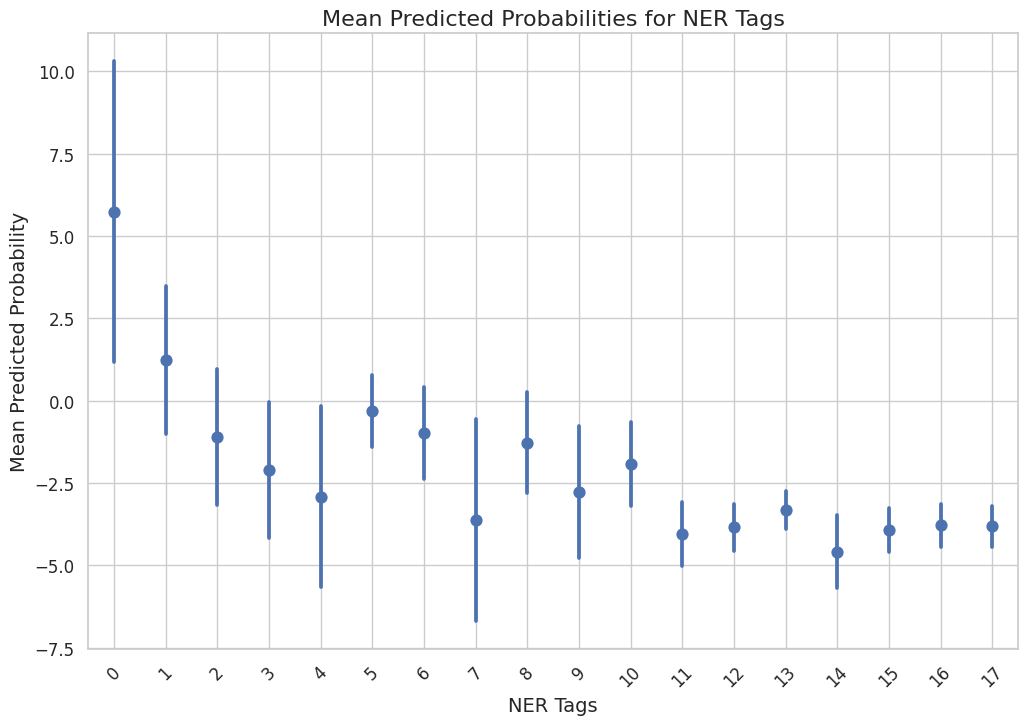

In [87]:
# Box Plot
plt.figure(figsize=(12, 8))
sns.boxplot(data=predictions[0], palette='tab10')
plt.title('Predicted Probabilities for NER Tags (Box Plot)', fontsize=16)
plt.xlabel('NER Tags', fontsize=14)
plt.ylabel('Predicted Probability', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

# Violin Plot
plt.figure(figsize=(12, 8))
sns.violinplot(data=predictions[0], palette='Pastel1')
plt.title('Distribution of Predicted Probabilities for NER Tags', fontsize=16)
plt.xlabel('NER Tags', fontsize=14)
plt.ylabel('Predicted Probability', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()

# Point Plot
plt.figure(figsize=(12, 8))
sns.pointplot(data=predictions[0], markers='o', join=False, ci='sd')
plt.title('Mean Predicted Probabilities for NER Tags', fontsize=16)
plt.xlabel('NER Tags', fontsize=14)
plt.ylabel('Mean Predicted Probability', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True)
plt.show()